In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import math

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
df = pd.read_csv(r'D:\OneDrive\ENG335\D05.SI.csv', index_col='Date', parse_dates=['Date'])

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,25.959999,26.120001,25.920000,26.110001,22.861399,2063600
2020-01-03,26.170000,26.320000,25.830000,26.000000,22.765083,4336600
2020-01-06,25.799999,25.930000,25.799999,25.860001,22.642504,5928500
2020-01-07,26.129999,26.190001,25.959999,26.049999,22.808863,8593000
2020-01-08,25.799999,25.840000,25.570000,25.730000,22.528673,14782300


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,505.0,2.579699e+01,4.417881e+00,17.120001,2.120000e+01,2.580000e+01,2.998000e+01,3.275000e+01
High,505.0,2.596990e+01,4.395458e+00,17.170000,2.143000e+01,2.602000e+01,3.012000e+01,3.280000e+01
Low,505.0,2.560119e+01,4.415892e+00,16.650000,2.102000e+01,2.570000e+01,2.977000e+01,3.269000e+01
Close,505.0,2.578855e+01,4.411163e+00,16.879999,2.125000e+01,2.586000e+01,2.992000e+01,3.278000e+01
Adj Close,505.0,2.408027e+01,4.609994e+00,14.779793,1.959109e+01,2.383952e+01,2.841506e+01,3.173967e+01
Volume,505.0,5.176707e+06,3.393764e+06,0.000000,3.116000e+06,4.204800e+06,5.928500e+06,3.016260e+07


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-01-02 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       505 non-null    float64
 1   High       505 non-null    float64
 2   Low        505 non-null    float64
 3   Close      505 non-null    float64
 4   Adj Close  505 non-null    float64
 5   Volume     505 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.6 KB


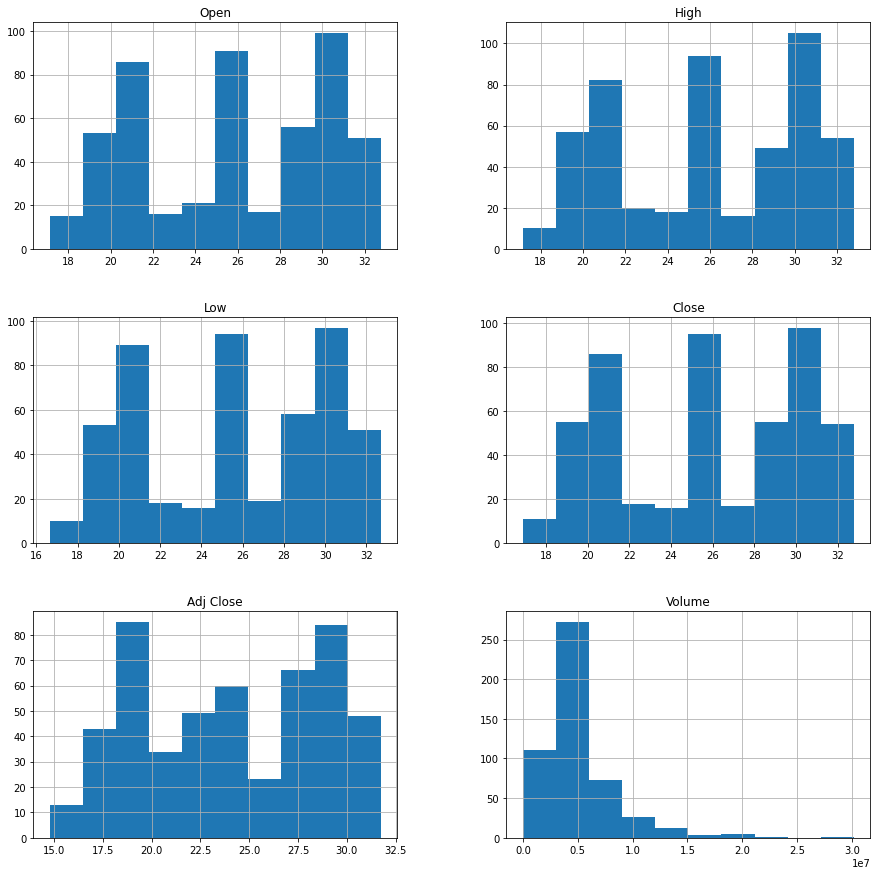

In [7]:
df.hist(figsize=(15,15))
plt.show()

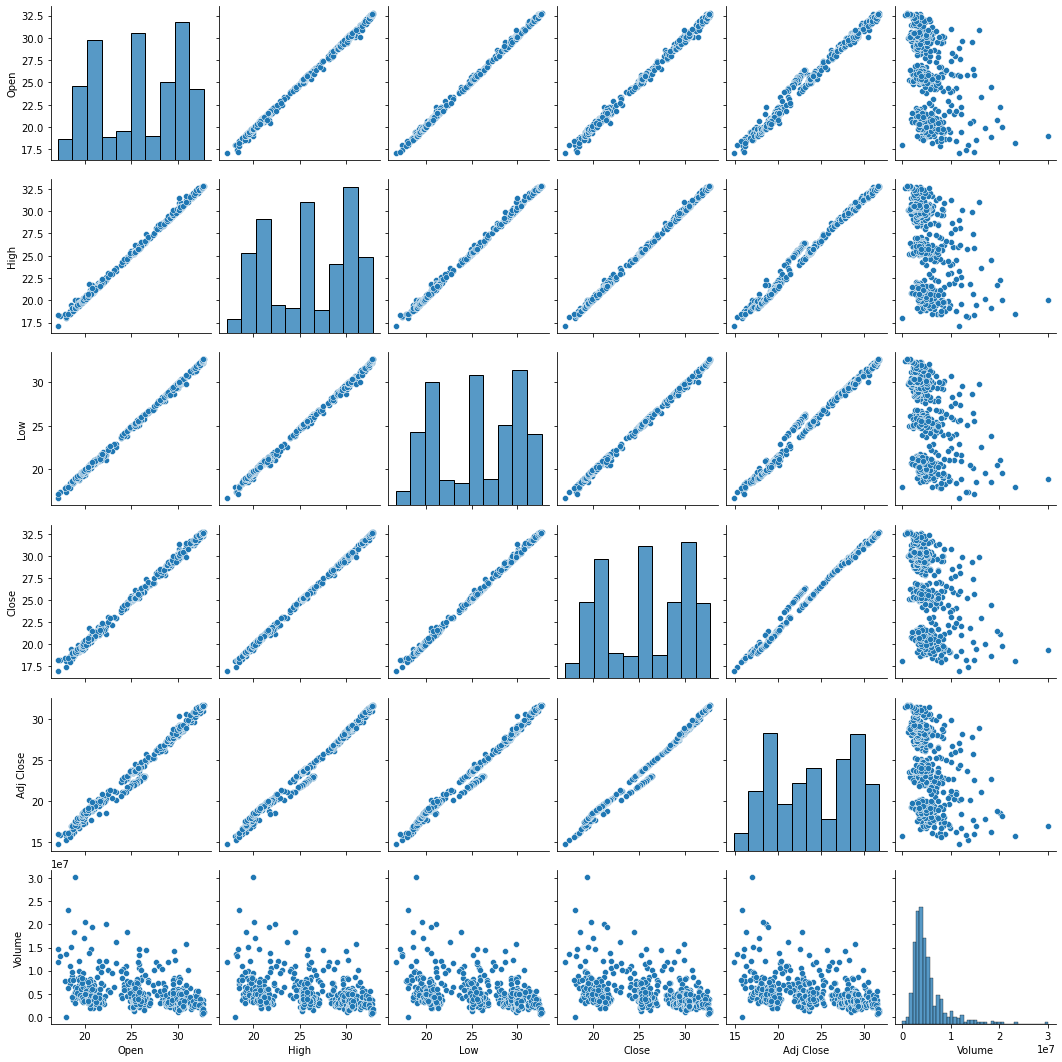

In [8]:
sns.pairplot(df)

# Use data until 31 Dec 2020 for training and the remaining data for testing

In [9]:
# extracting high values and creating the training and test data
#using the 2020 data set to predict the prices in 2021
training_set = df[:'2020'].iloc[:,1:2].values
test_set = df['2021':].iloc[:,1:2].values

In [10]:
training_set[0]

array([26.120001])

In [11]:
print(len(training_set))
print(len(test_set))

252
253


In [12]:
df['2021':].iloc[:,1:2]

,High
Date,
2021-01-04,25.340000
2021-01-05,25.350000
2021-01-06,25.350000
2021-01-07,26.180000
2021-01-08,27.469999
...,...
2021-12-27,32.650002
2021-12-28,32.750000
2021-12-29,32.799999


Text(0.5, 1.0, 'Closing Price of DBS}')

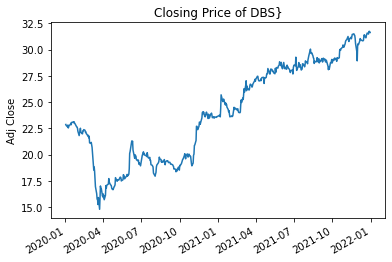

In [13]:
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title("Closing Price of DBS}")

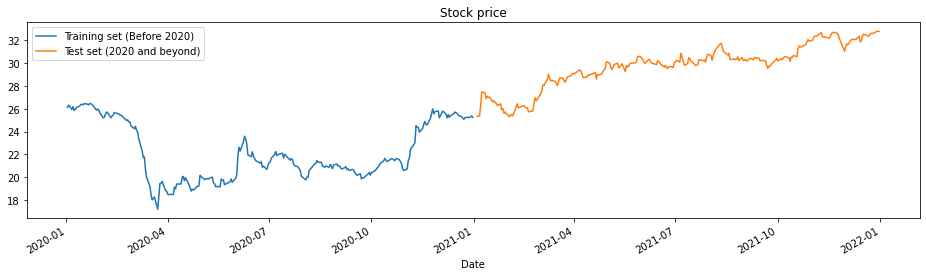

In [14]:
#extracts the "High" column corresponding to the dates in 2020, does a ling plor and creates a legend
df["High"][:'2020'].plot(figsize=(16,4),legend=True) 

#extracts the "High" column corresponding to the dates in 2021, does a ling plor and creates a legend
df["High"]['2021':].plot(figsize=(16,4),legend=True)

plt.legend(['Training set (Before 2020)','Test set (2020 and beyond)'])
plt.title('Stock price')
plt.show()

In [15]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [16]:
training_set_scaled.shape

(252, 1)

# Use previous 30 days of stock information to predict the next day stock price

In [17]:
# Since LSTMs store long term memory state, we create a data structure with 30 timesteps and 1 output
# So for each element of training set, we have 30 previous training set elements 
X_train = []
y_train = []
for i in range(30,len(training_set_scaled)):#
    X_train.append(training_set_scaled[i-30:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
print(X_train.shape)
print(y_train.shape)

(222, 30)
(222,)


In [19]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

 # LSTM network to do the predictions with cell state of at least 60 dimension and do at least 50 epochs of training

In [20]:
print('Build model...')
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=60, input_shape=(30,1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(1))
# Compiling the model
model.compile(loss='mean_squared_error')
print (model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                14880     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
7/7 [==============================] - 2s 8ms/step - loss: 0.0915
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0241
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0185
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0117
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0108
Epoch 11/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 12/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0107
Epoch 13/50
7/7 [==============================] - 0s 8ms/step - loss: 0.

In [22]:
# Now to get the test set ready in a similar way as the training set.
dataset_total = pd.concat((df["High"][:'2020'],df["High"]['2021':]),axis=0)
start_index = len(dataset_total)-len(test_set) - 30
inputs = dataset_total[start_index:].values

In [23]:
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [24]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(30,len(inputs)):
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [25]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

8/8 [==============================] - 0s 3ms/step


(253, 1)

In [26]:
train_predict=model.predict(X_train)
train_predict = sc.inverse_transform(train_predict)
train_predict.shape

7/7 [==============================] - 0s 3ms/step


(222, 1)

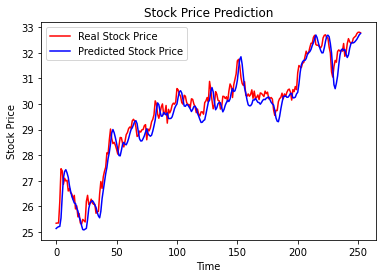

In [27]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

# Predicting

In [28]:
real_data = [inputs[len(inputs)+1 - 30:len(inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [29]:
prediction = model.predict(real_data)
prediction = sc.inverse_transform(prediction)
print(f"prediction: {prediction}")

1/1 [==============================] - 0s 329ms/step
prediction: [[32.762135]]


# Evaluation

In [30]:
y_train.shape

(222,)

In [31]:
train_predict.shape

(222, 1)

In [32]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 0.4033931588233172.


In [33]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train, train_predict)))
print("Train data MSE: ", mean_squared_error(y_train, train_predict))
print("Train data MAE: ", mean_absolute_error(y_train, train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_set,predicted_stock_price)))
print("Test data MSE: ", mean_squared_error(test_set,predicted_stock_price))
print("Test data MAE: ", mean_absolute_error(test_set,predicted_stock_price))

Train data RMSE:  21.293650200002407
Train data MSE:  453.4195388400625
Train data MAE:  21.212803444794254
-------------------------------------------------------------------------------------
Test data RMSE:  0.4033931588233172
Test data MSE:  0.16272604058545403
Test data MAE:  0.31312480036920215


In [34]:
print("Train data explained variance regression score:", 
      explained_variance_score(y_train, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(test_set,predicted_stock_price))

Train data explained variance regression score: -61.12037334178246
Test data explained variance regression score: 0.9644684820882815


In [35]:
print("Train data R2 score:", r2_score(y_train, train_predict))
print("Test data R2 score:", r2_score(test_set,predicted_stock_price))

Train data R2 score: -8195.280656165898
Test data R2 score: 0.9559697049951101
